<a href="https://colab.research.google.com/github/RafaelEstatistico/SAS_TOOLBOX/blob/master/Classifica%C3%A7%C3%A3o_de_Imagens_com_Redes_Neurais_Convolucionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Imagens com Redes Neurais Convolucionais 

Segue aqui os códigos utilizados na postagem do [Blog](https://hackmd.io/@Rafael/CNN_Blog). 

Caso esteja logado em sua conta Gmail sinta-se a vontade de executar passo-a-passo do código e testar suas próprias variáções.

## Trabalhando com Imagens


In [1]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np

# Url da imagem 
url = 'https://drive.google.com/uc?export=view&id=1jUQolidhePedzY_JaRPFfrPa-v75HnVT'
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Transfoma a imagem em matriz
image = np.array(image)

print('As dimensões da imagem importada são {} x {} x {}'.format(*image.shape))

As dimensões da imagem importada são 384 x 512 x 3


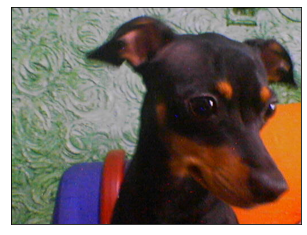

In [2]:
import matplotlib.pyplot as plt

# Figura Importada
plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.show()

### Figura em RGB

In [3]:
from numpy import array, zeros_like

titles = ['Original', 'Red', 'Green', 'Blue']

def channel(image, color):
    if color not in (0, 1, 2): return image
    c = image[..., color]
    z = zeros_like(c)

    # Substitui por zero os outros dois canais
    return array([(c, z, z), (z, c, z), (z, z, c)][color]).transpose(1,2,0)

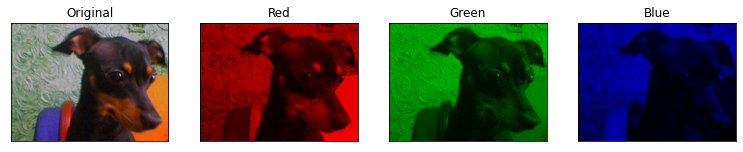

In [4]:
colors = range(-1, 3) # Cor: Original, Red, Green, Blue

fig, axes = plt.subplots(1, 4, figsize=(13,3))
objs = zip(axes, titles, colors)

for ax, title, color in objs:
    ax.imshow(channel(image, color))
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())

### Camada de Convolução

Utilizando a figura importada vamos testar munalmente alguns filtros de convolução.

In [194]:
def ManualConv(image, filter):
    conv = []
    for c in range(image.shape[2]):
        img = image[:,:,c]
        sub_shape = filter.shape
        view_shape = tuple(np.subtract(img.shape, sub_shape) + 1) + sub_shape
        strides = img.strides + img.strides
        sub_matrices = np.lib.stride_tricks.as_strided(img,view_shape,strides)
        prod = np.einsum('ij,klij->kl',filter,sub_matrices)
        conv.append(prod)

    conv = np.array(conv)

    # Soma as 3 dimensões: R,G,B
    conv = conv.sum(axis=0)
    
    return conv

In [195]:
# Estamos aplicando 3 diferentes tipos de kernel na imagem
conv_filter = np.array([ [[-1,-2,-1],[0,0,0],[1,2,1]],
                         [[-2,-1,0],[-1,1,1],[0,1,2]],
                         [[1,0,-1],[2,0,-2],[1,0,-1]] ])

conv_img = []
for i in range(conv_filter.shape[2]):
    cimg = ManualConv(image, conv_filter[i,:,:])
    conv_img.append(cimg)

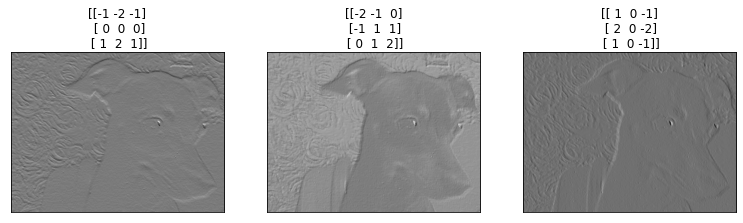

In [196]:
pos = np.arange(3)
titles = [str(img) for img in conv_filter]

fig, axes = plt.subplots(1, 3, figsize=(13,3))
objs = zip(axes, titles, pos)

for ax, title, pos in objs:
    ax.imshow(conv_img[pos], cmap=plt.get_cmap('gray'))
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())

---
### Camada de Agrupamento

In [425]:
import numpy as np
import skimage.measure


def maxpool(image, pool):
    img = []
    
    for c in range(image.shape[2]):
        MaxPool = skimage.measure.block_reduce(image[:,:,c], pool, np.max)
        img.append(MaxPool)
    
    saida = np.zeros((*MaxPool.shape,3), dtype=int)
    for i in range(len(img)): 
        saida[:,:,i] = np.array(img[i])

    return saida

In [426]:
# Estamos aplicando 3 diferentes tipos de kernel na imagem
pool_filter = np.array([ (2,2),
                         (6,6),
                         (15,15)])

pool_img = []
for i in range(pool_filter.shape[0]):
    pimg = maxpool(image, tuple(pool_filter[i,:]))
    pool_img.append(pimg)

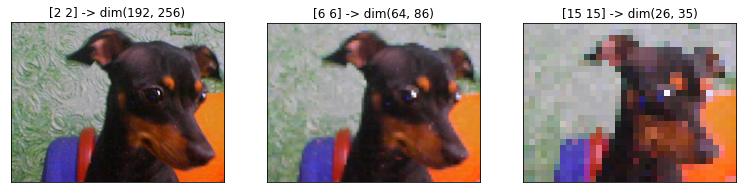

In [427]:
pos = np.arange(3)
titles = [str(img) for img in pool_filter]
shapes = [str(x.shape[0:2]) for x in pool_img]

fig, axes = plt.subplots(1, 3, figsize=(13,3))
objs = zip(axes, titles, shapes, pos)

for ax, title, shape, pos in objs:
    ax.imshow(pool_img[pos], cmap=plt.get_cmap('gray'))
    ax.set_title(title + ' -> dim' + shape)
    ax.set_xticks(())
    ax.set_yticks(())

---
## Aplicação

Esta aplicação utilizara o pacote Keras e é baseada no exemplo na [página do Tensorflow](https://www.tensorflow.org/tutorials/images/cnn)

In [455]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

## Download e Preparação dos dados

O dataset CIFAR10 possui 60.000 imagens coloridas classificadas em 10 categorias balanceadas, isto é, cada categoria possui 6 mil imagens. 
Os dados estão divididos em 50.000 imagens para treinamento e 10.000 para testes. 

Vale ressaltar que as classes são mutualmente exclusivas, não há imagens com mais de uma categoria presente.


In [456]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalização de Pixels entre 0 e 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [457]:
print('As dimensões das imagens importada são {} x {} x {}'.format(*train_images[0].shape))

As dimensões das imagens importada são 32 x 32 x 3


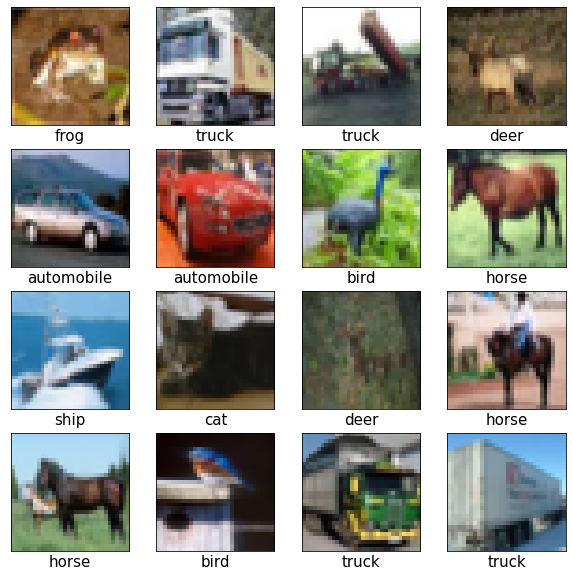

In [458]:
# Visualizando uma amostra dos dados
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)

    plt.xlabel(class_names[train_labels[i][0]], fontsize=15)
plt.show()

## Modelagem 



### Camadas de Convolução e MaxPooling

In [465]:
model = models.Sequential(name='CNN-CIFAR10')
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [466]:
model.summary()

Model: "CNN-CIFAR10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________


In [467]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [468]:
model.summary()

Model: "CNN-CIFAR10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                147520    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                

## Treinando Modelo

In [469]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 70s 45ms/step - loss: 1.4475 - accuracy: 0.4780 - val_loss: 1.2009 - val_accuracy: 0.5760
Epoch 2/10
1563/1563 [==============================] - 69s 44ms/step - loss: 1.0965 - accuracy: 0.6180 - val_loss: 1.0286 - val_accuracy: 0.6467
Epoch 3/10
1563/1563 [==============================] - 69s 44ms/step - loss: 0.9588 - accuracy: 0.6670 - val_loss: 1.0581 - val_accuracy: 0.6343
Epoch 4/10
1563/1563 [==============================] - 68s 43ms/step - loss: 0.8696 - accuracy: 0.6985 - val_loss: 0.9627 - val_accuracy: 0.6658
Epoch 5/10
1563/1563 [==============================] - 68s 43ms/step - loss: 0.8032 - accuracy: 0.7198 - val_loss: 0.9483 - val_accuracy: 0.6799
Epoch 6/10
1563/1563 [==============================] - 68s 44ms/step - loss: 0.7475 - accuracy: 0.7405 - val_loss: 0.8877 - val_accuracy: 0.7019
Epoch 7/10
1563/1563 [==============================] - 68s 43ms/step - loss: 0.6947 - accuracy: 0.7575 - val_loss: 0.8994 -

## Mensurando Modelo

In [470]:
# Acurácia de Validação
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 4s - loss: 0.9444 - accuracy: 0.6890


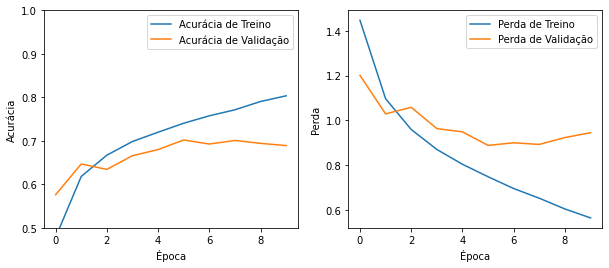

In [476]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label = 'Acurácia de Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.ylim([0.5, 1])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label = 'Perda de Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(loc='upper right')

plt.show()

In [477]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

In [478]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i][0], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i][0]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
# Probabilidades de Predição
predictions[i]

array([4.9246610e-06, 2.5020142e-08, 9.2489255e-04, 9.5526746e-04,
       9.1535211e-01, 8.1634998e-02, 3.3120348e-05, 1.0918552e-03,
       1.3513055e-06, 1.3739278e-06], dtype=float32)

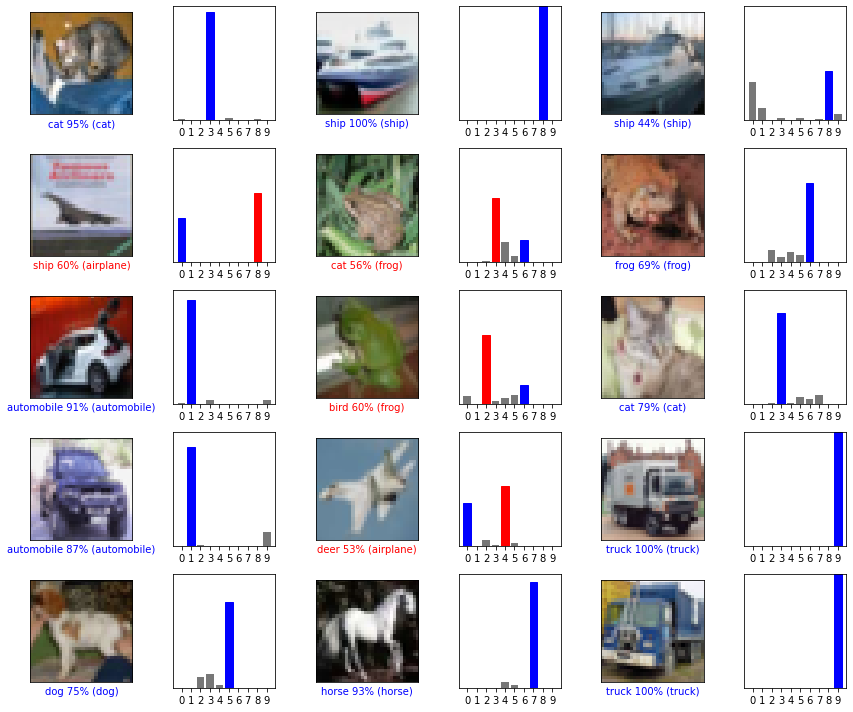

In [479]:
# Previzões corretas são marcadas em azul, erradas em vermelho
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [483]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels,predictions.argmax(1) )

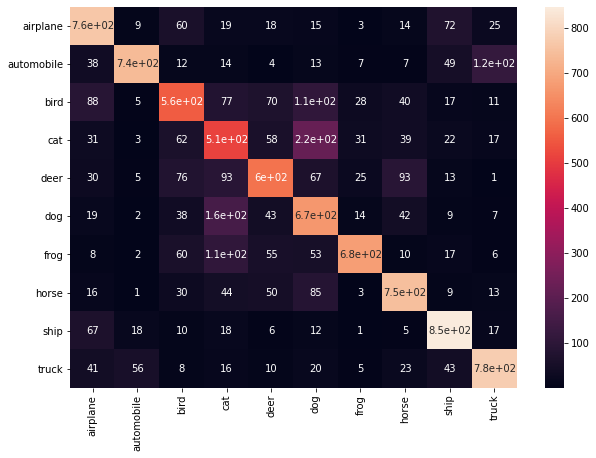

In [488]:
import pandas as pd
import seaborn as sn

df_cm = pd.DataFrame(cm, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()